In [1]:
# This notebook is used for testing plant models in the draculab module.

# By Sergio Verduzco Flores        June 2017

# This file is supposed to be in .../draculab/tests/ , so cd before importing:
%cd ..
from draculab import *
from matplotlib import pyplot as plt
import re

/home/z/projects/draculab


In [2]:
def loadData(filename):
    # Receives the name of a datafile saved in XPP's .dat format, 
    # and returns numpy arrays with the data from the columns
    # The format is simply putting in each line the values of time and state variables
    # separated by spaces. Time is the first column.
    
    # Counting the lines and columns in order to allocate the numpy arrays
    nlines = sum(1 for line in open(filename,'r'))
    n_columns = len(re.split(' .', open(filename,'r').readline()))
    # XPP puts an extra space at the end of the line, so I used ' .' instead of ' '
    
    # We'll store everything in one tuple of numpy arrays, one per column
    values = tuple(np.zeros(nlines) for i in range(n_columns))
    for idx, line in enumerate(open(filename,'r')):
        listed = re.split(' ', re.split(' $', line)[0]) # the first split removes the trailing space
        for jdx, value in enumerate(listed):  
            values[jdx][idx] = float(value) 
    return values

def align_points(times, data_times, data_points):
    """ Returns the data_points interpolated at the points in 'times'. """
    data_fun = interp1d(data_times, data_points)
    return np.array([data_fun(t) for t in times])

XPP is modeling a simple pendulum, which means all the mass is concentrated at the endpoint.
Draculab is modeling a compound pendulum, using a rod with homogeneous mass distribution.

In both cases, the equation of motion comes from $\tau = I \ddot{\theta}$, but there are two differences:
* In the simple pendulum the moment of inertia is $I=mL^2$, whereas in the compound pendulum it is $I=mL^2/3$.
* In the simple pendulum the torque due to gravity is $-mgL \cos(\theta)$, but in the compound pendulum it is $-mgL/2 \cos(\theta)$.

The simple pendulum has the equation: 
$ \ddot{\theta} = - (g/L_s) \cos(\theta) - \mu_s /(m L_s^2) \dot{\theta}$

The compound pendulum has the equation: 
$ \ddot{\theta} = - (3/2)(g/L_c) \cos(\theta) - 3\mu_c /(m L_c^2) \dot{\theta}$

In order to make the models equivalent we need to set $L_c = (3/2)L_s, \mu_c = (3/4) \mu_s$.

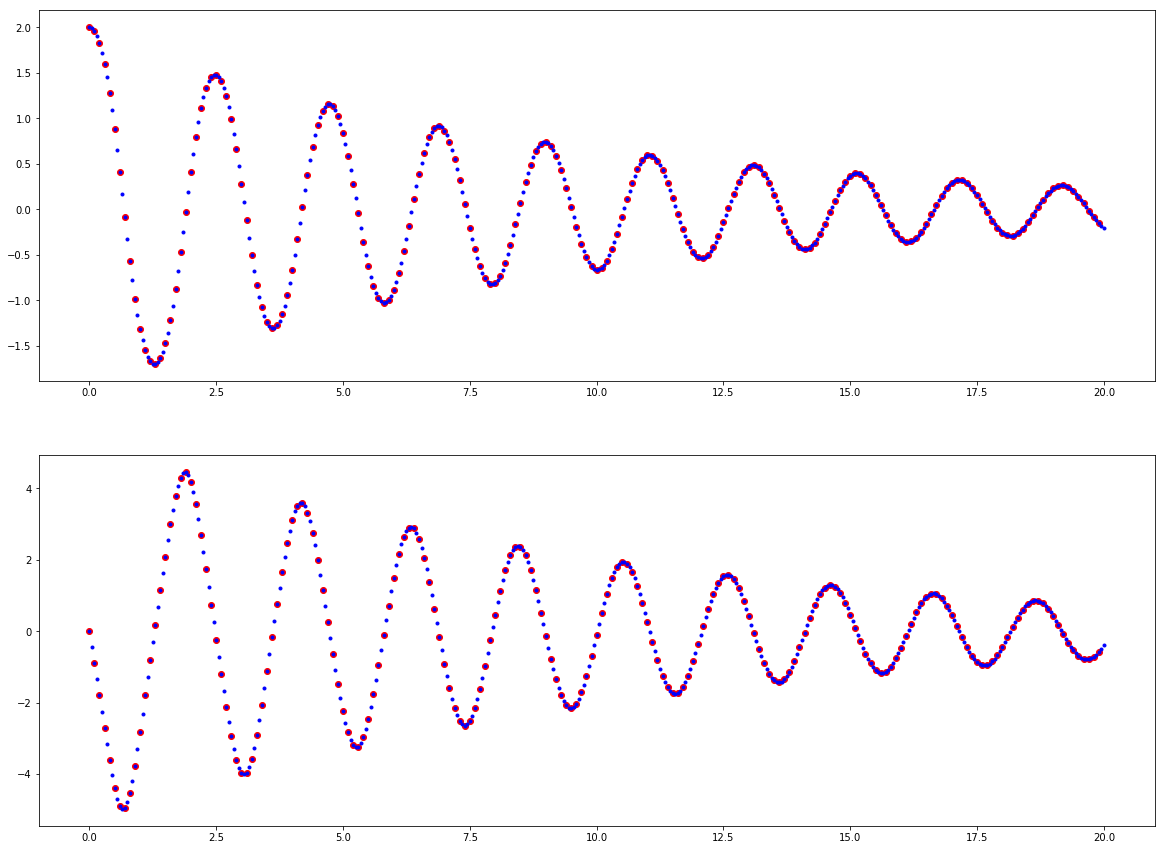

In [3]:
'''
    This cell performs the same simulation as in the file pend.ode, which is one of the 
    examples distributed with XPPAUT. It also compares draculab VS XPPAUT output. 
'''
net_params = {'min_delay' : 0.1, 'min_buff_size' : 4 } # parameter dictionary for the network
n1 = network(net_params)

# Notice the XPP model uses a massless rod with a mass at the end, so I need L_c=1.5*L_s,
# mu_c = 0.75 mu_s
# Moreover, the angles are measured wrt different axes, so init_angle = 2 - pi/2
plant_params = {'type' : plant_models.pendulum,
          'length' : 1.5 * 1.0, 'mass' : 10., 'mu' : 0.75 * 2.,
          'init_angle' : 2.-(np.pi/2.), 'init_ang_vel' : 0.}
n1.create(1, plant_params) # create a plant

# Run the simulation
sim_dat = n1.flat_run(20.)

# In pend.ode the zero angle aligns with the negative Y axis
sim_dat[2][0][:,0] = sim_dat[2][0][:,0] + np.pi/2

xpp_dat = loadData('./tests/pendoderun.dat')

fig = plt.figure(figsize=(20,15))
plt.subplot(211)
plt.plot(sim_dat[0], sim_dat[2][0][:,0], 'ro', xpp_dat[0], xpp_dat[1], 'b.', figure=fig)
plt.subplot(212)
plt.plot(sim_dat[0], sim_dat[2][0][:,1], 'ro', xpp_dat[0], xpp_dat[2], 'b.', figure=fig)
plt.show()

0.00022875363317667596


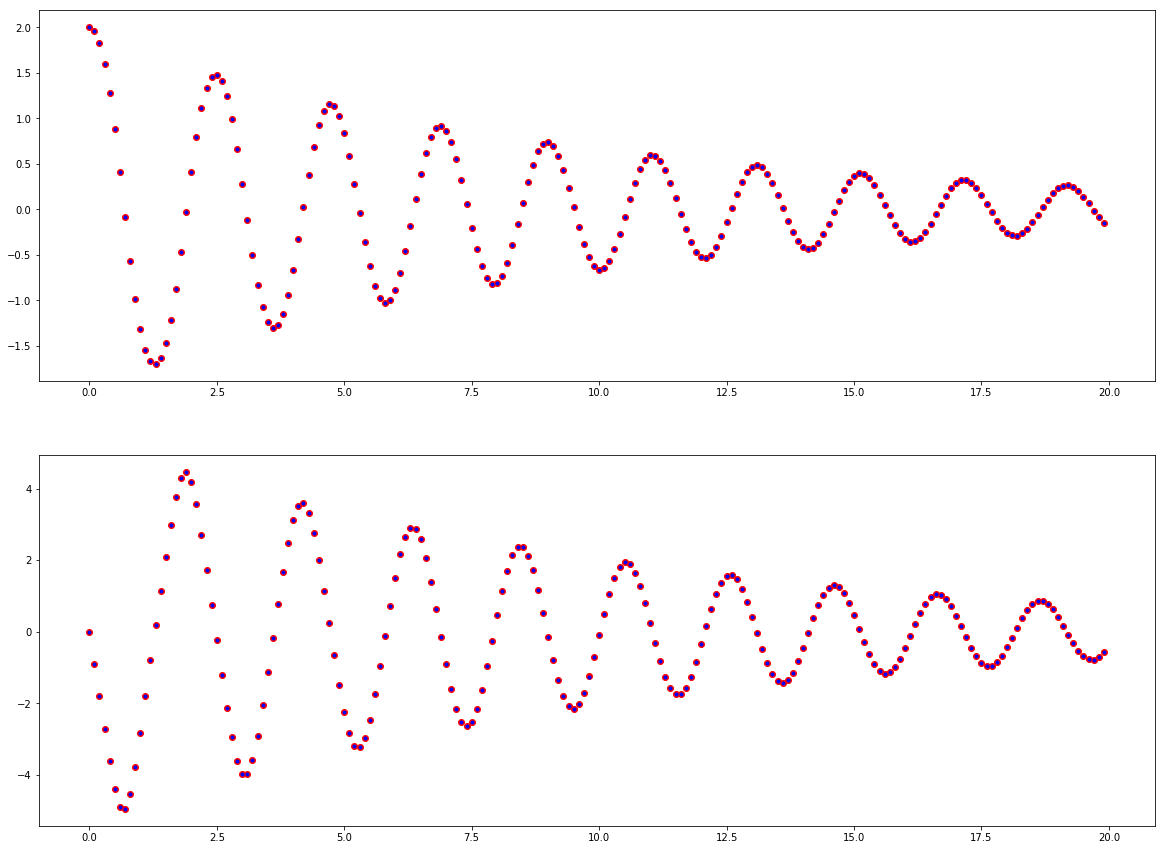

In [4]:
xpp_points1 = align_points(sim_dat[0], xpp_dat[0], xpp_dat[1])
xpp_points2 = align_points(sim_dat[0], xpp_dat[0], xpp_dat[2])

diff1 = max(np.abs(xpp_points1-sim_dat[2][0][:,0]))
diff2 = max(np.abs(xpp_points2-sim_dat[2][0][:,1]))
max_diff = max(diff1, diff2)
print(max_diff)

fig = plt.figure(figsize=(20,15))
plt.subplot(211)
plt.plot(sim_dat[0], sim_dat[2][0][:,0], 'ro', sim_dat[0], xpp_points1, 'b.', figure=fig)
plt.subplot(212)
plt.plot(sim_dat[0], sim_dat[2][0][:,1], 'ro', sim_dat[0], xpp_points2, 'b.', figure=fig)
plt.show()

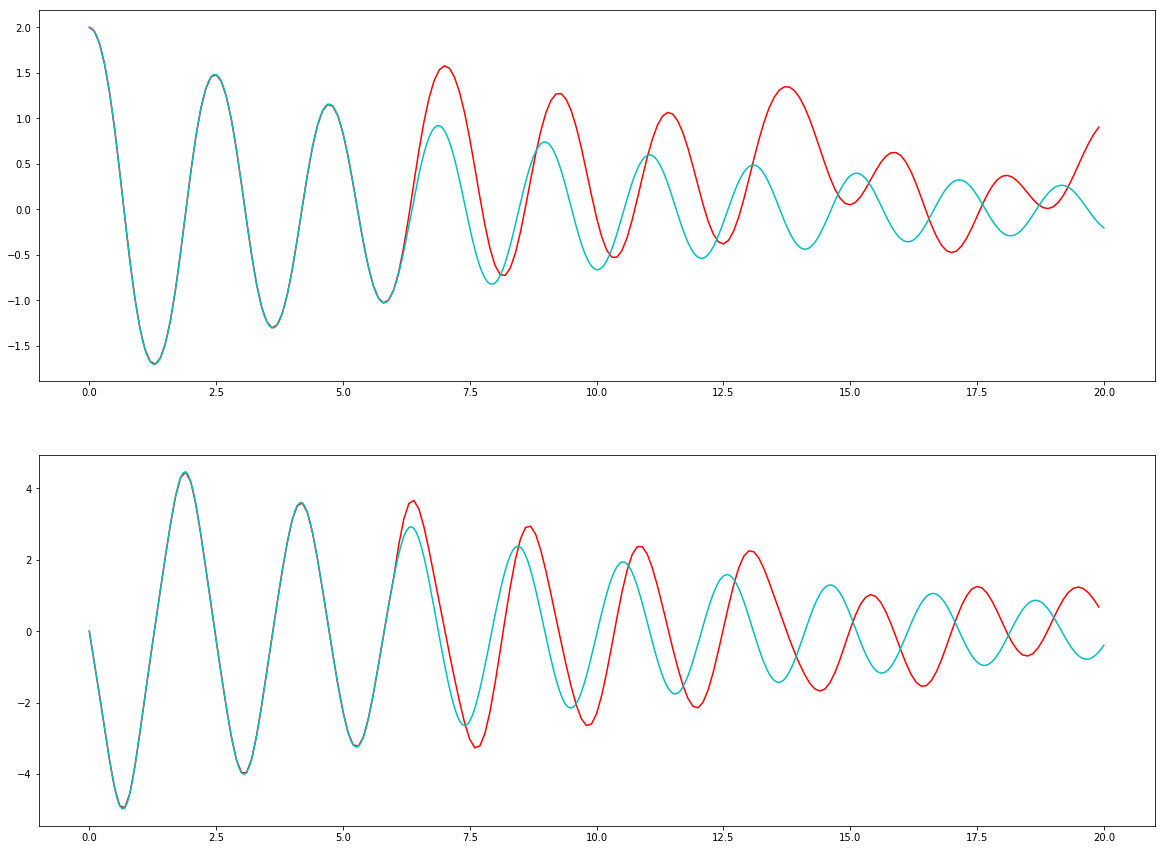

In [12]:
'''
This cell is meant to test the set_plant_input function for 1-dimensional input
'''
# Create parameter dictionaries
plant_params = {'type' : plant_models.pendulum, 'length' : 1.5, 'inp_gain' : 10.,
                'mass' : 10., 'mu' : 1.5, 'init_angle' : 2.-(np.pi/2.), 'init_ang_vel' : 0.}
unit_pars = { 'init_val' : 0.5, 'function' : lambda x: None, 'type' : unit_types.source } 
net_params = {'min_delay' : 0.1, 'min_buff_size' : 4 } # parameter dictionary for the network

# Create network, plant, and input units
n2 = network(net_params)  # creating a newtwork
units = n2.create(2,unit_pars) # source units
pend = n2.create(1,plant_params) # and a pendulum

# Create some inputs
f1 = lambda x : np.sign(max(0.,x-5.))*4. # 0 for x<5, 4 for x>5
f2 = lambda x : 2.*np.sin(max(0.,x-10.)) # 0 for x<10, 2*sin(x) for x>10
n2.units[units[0]].set_function(f1)
n2.units[units[1]].set_function(f2)

# Connect the source units to the pendulum
conn_spec = {'inp_ports' : [0, 0],
             'delays' : [1.0, 2.5]} # connection specification dictionary
syn_pars = {'init_w' : [0.5, 1.2], 'type' : synapse_types.static} # synapse parameters dictionary
n2.set_plant_inputs(units, pend, conn_spec, syn_pars)

# Run the simulation
sim_dat = n2.flat_run(20.)

# In pend.ode the zero angle aligns with the negative Y axis
sim_dat[2][0][:,0] = sim_dat[2][0][:,0] + np.pi/2

xpp_dat = loadData('./tests/pendoderun.dat')

fig = plt.figure(figsize=(20,15))
plt.subplot(211)
plt.plot(sim_dat[0], sim_dat[2][0][:,0], 'r', xpp_dat[0], xpp_dat[1], 'c', figure=fig)
plt.subplot(212)
plt.plot(sim_dat[0], sim_dat[2][0][:,1], 'r', xpp_dat[0], xpp_dat[2], 'c', figure=fig)
plt.show()

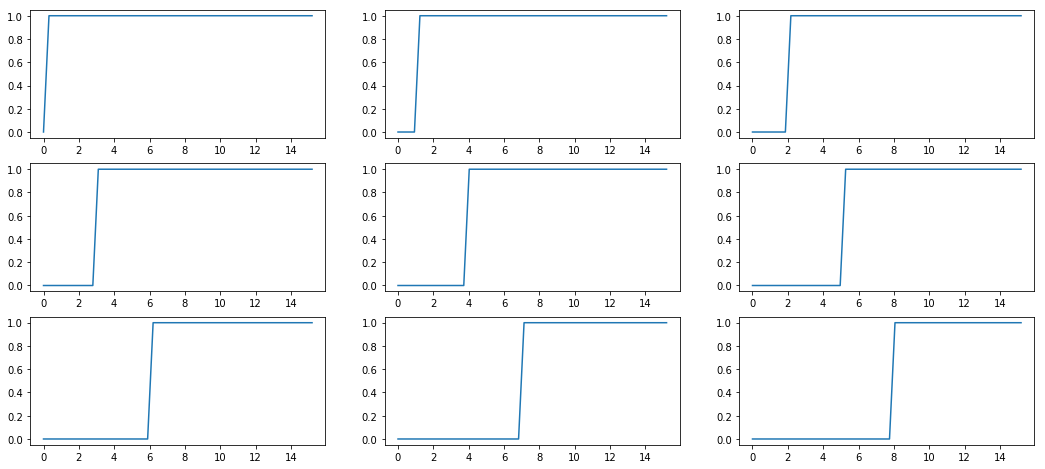

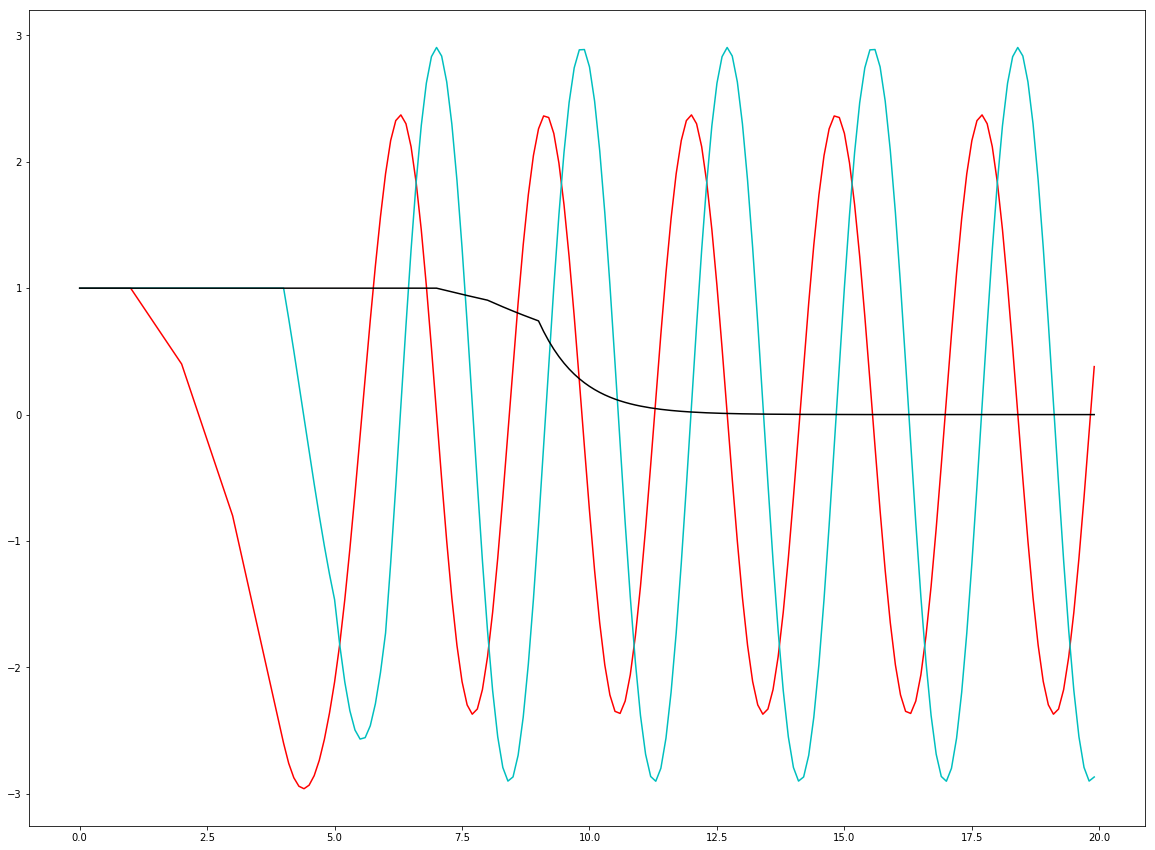

In [13]:
'''
This cell is meant to test the set_plant_input function for multidimensional input
'''
# Create parameter dictionaries
plant_params = {'type' : plant_models.conn_tester, 'init_state' : [1.,1.,1.]}
unit_pars = { 'init_val' : 0.5, 'function' : lambda x:None, 'type' : unit_types.source } 
net_params = {'min_delay' : 0.1, 'min_buff_size' : 4 } # parameter dictionary for the network

# Create network, plant, and input units
n3 = network(net_params)  # creating a newtwork
units = n3.create(9,unit_pars) # source units
pend = n3.create(1,plant_params) # and a pendulum

# Create some inputs
def make_Heavi(thr):
    return lambda x : np.sign(max(0.,x - float(thr)))

for idx, unit in enumerate(n3.units):  # Heaviside step functions with increasing thresholds
    unit.set_function(make_Heavi(float(idx)))

# plotting inputs
tims = np.linspace(0.,15.200)
inp_fig2 = plt.figure(figsize=(18,8))
for idx,unit in enumerate(n3.units):
    vals = list(map(unit.get_act, tims))
    plt.subplot(3,3,unit.ID+1)
    plt.plot(tims,vals)
    
# Connect the source units to the plant
conn_spec = {'inp_ports' : [0, 0, 0, 1, 1, 1, 2, 2, 2], 
             'delays' : [1.]*9} # connection specification dictionary
syn_pars = {'init_w' : [.6,.6,.6,.9,.9,.9,.1,.1,1.], 'type' : synapse_types.static} # synapse parameters dictionary
n3.set_plant_inputs(units, pend, conn_spec, syn_pars)

# Run the simulation
sim_dat = n3.flat_run(20.)

fig = plt.figure(figsize=(20,15))

plt.plot(sim_dat[0], sim_dat[2][0][:,0], 'r', figure=fig)
plt.plot(sim_dat[0], sim_dat[2][0][:,1], 'c', figure=fig)
plt.plot(sim_dat[0], sim_dat[2][0][:,2], 'k', figure=fig)

plt.show()